# Final Case Study
## Team : Samuel Arellano, Daniel Clark, Dhyan Shah, Chandler Vaugh

In [18]:
%matplotlib inline

import numpy as np
import pandas as pd
#import modin.pandas as pd
import matplotlib.pyplot as plt
import altair as alt

#import cufflinks as cf
#cf.go_offline()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import numpy as np
import seaborn as sns; sns.set()

from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp

# Goal

Given an unknown dataset. Predict the response **y** using a feature set comprised of the variables **x0 : x49**.

Identify the optimized model and feature set that maximizes accuracy and minimizes cost given the following constraints:

Each False Positive increases cost by `$`10  <br>
Each False Negative inreases cost by `$`500 <br>

True Predictions will not increase cost. <br>


In [3]:
#df = pd.read_csv ('./final_project.csv')
df = pd.read_csv("/Users/Dhyan/QTW/QTW_Final/final_project.csv")

# Data

The data set consists 160,000 observations that record the response variable **y** and up to 50 potential predictive variables **x0 : x49**. While it is unknown what the variables represent, it is known that the response variable is binary and in each of the recorded observations it has the value of either 0 or 1. Accross the data set there are 1608 missing values. Therefore, applying listwise deletion to address the missing data would result in a loss of up to 1% of the observations. 

A preliminary review of the dataset indicates that within the predictive variable set, there are a total of 46 numerical variables and 4 categorical variables. The four categorical variables are (**x24, x29, x30, x32**). 

In [4]:
print("Records and Fields: ", df.shape)
print("Total Missing Values: ", df.isnull().sum().sum())

Records and Fields:  (160000, 51)
Total Missing Values:  1608


A closer review of the categorical variables indicates that variable **x32** is likely a numerical variable that represents a percentage. Subsequently, variable **x32** was then coded as a float type and missing values were checked to ensure that no missing values were inadvertantly imputed or dropped inadvertantly.

In [5]:
cat = ["x24","x29","x30","x32"]
print(df[cat].describe(), "\n")

df["x32"] = df["x32"].str.rstrip('%')
df["x32"] = df["x32"].apply(pd.to_numeric, errors='coerce').astype('float64')

print("Total Missing Values: ", df.isnull().sum().sum()) 

           x24     x29        x30     x32
count   159972  159970     159970  159969
unique       3      12          5      12
top       asia    July  wednesday   0.01%
freq    138965   45569     101535   40767 

Total Missing Values:  1608


In [6]:
cat = ["x24","x29","x30"]
df[cat].head()

,x24,x29,x30
0,euorpe,July,tuesday
1,asia,Aug,wednesday
2,asia,July,wednesday
3,asia,July,wednesday
4,asia,July,tuesday


A review of the categorical variables indicates that variable **x24** might represent a continent or region and that within the variable there are 3 unique values. Variable **x29** seems to represent a calendar month and contains 12 unique values. Lastly, variable **x30** seem to represent a weekday and contains 5 unique values. Missing values whithin each field range from 28 to 30. 

In [7]:
print("Total Missing Values:") 
print(df[cat].isnull().sum())

Total Missing Values:
x24    28
x29    30
x30    30
dtype: int64


At most, only 88 observations or .05% of the total observations would be lost through listwise deletion of missing categorical values and according to our own studies along with those of researchers like that of Paul D. Allison of the University of Pennsylvania, listwise deletion of categorical variables can achieve results similar to more complicated methods like that of the Markov Chain Monte Carlo (MCMC) algorithm used in popular imputation processes.  Therefore we decided to delete the observations in which a categorical variable had missing data rather than risk introducing bias through imputation. This decision was heavily influenced by the fact that we did not know if the data was missing at random or if there was an underlying correlation between a value being missing and another variable.  

In [8]:
df = df.dropna(subset=['x24', 'x29','x30'])
print("Total Missing Values: ", df.isnull().sum().sum()) 

Total Missing Values:  1520


Because little was known about the numerical variables or their potential interactions and associations, no additional preprocessing was done before moving on to exploratory data analysis.  

# EDA

Although we do not know what the response variable y represents, we will refer to values of 1 as a positive response and values of 0 as a negative response for the sake of simplyfying the explanation of our findings and methodology in the exploratory data analysis and going forward.

#### Label Distribution

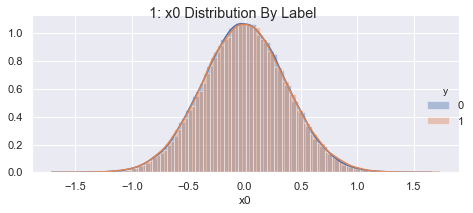

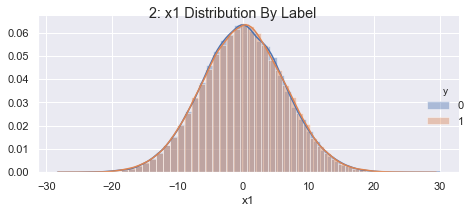

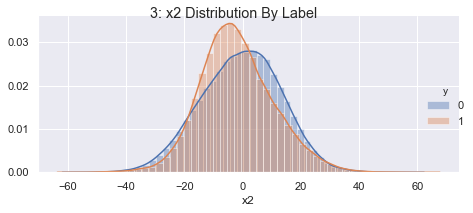

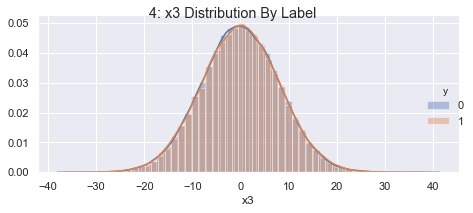

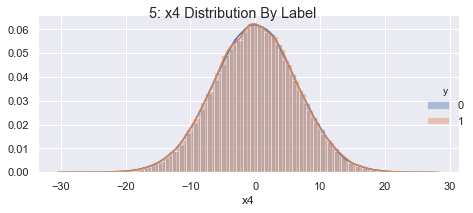

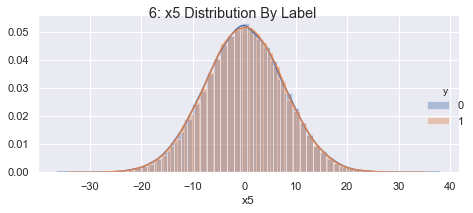

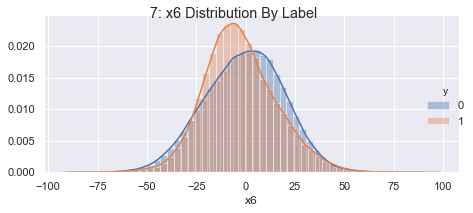

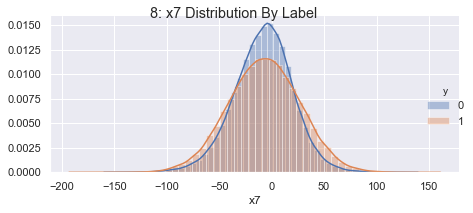

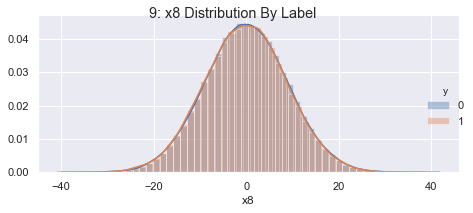

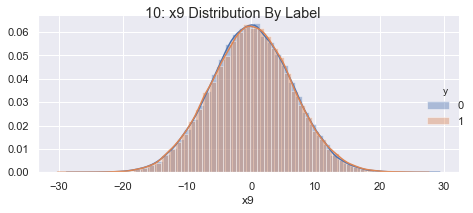

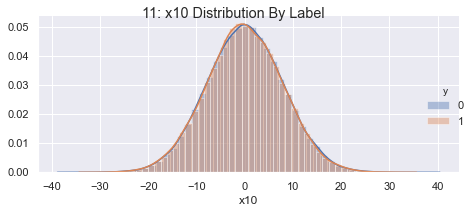

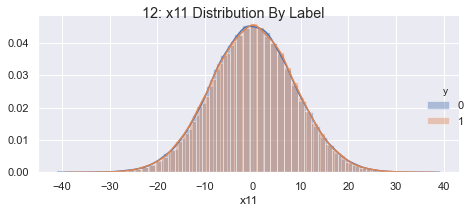

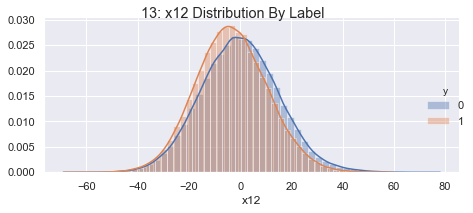

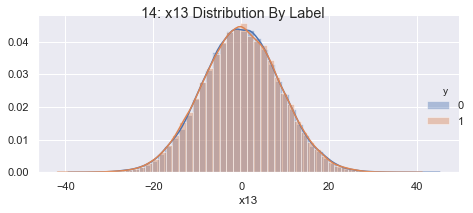

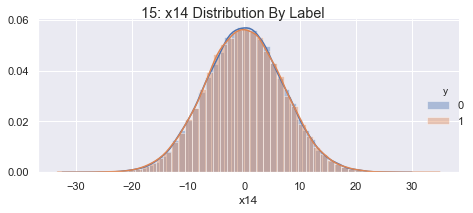

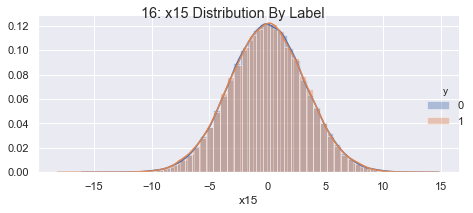

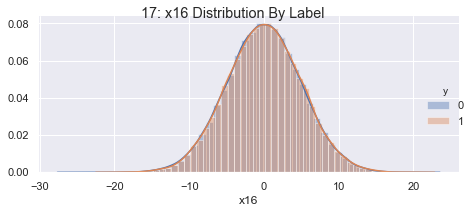

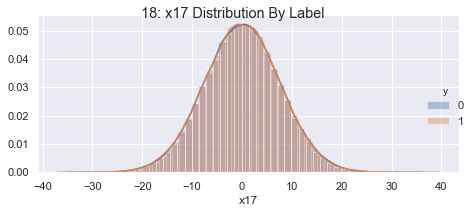

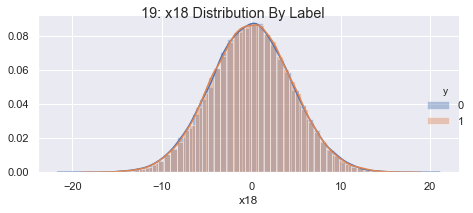

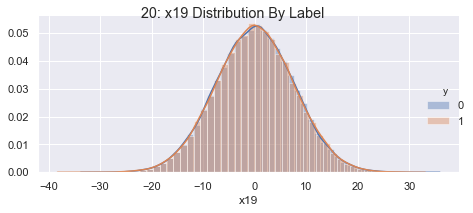

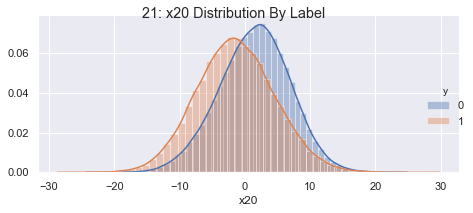

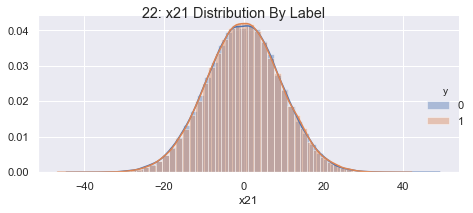

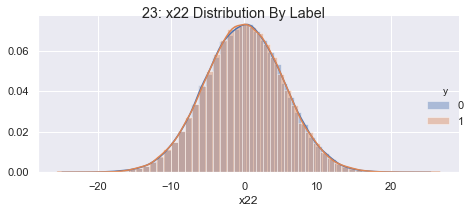

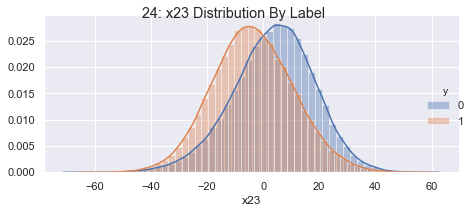

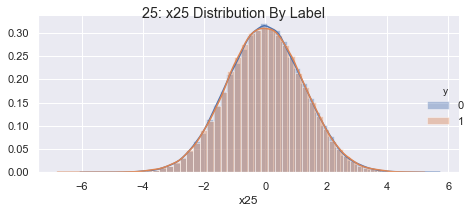

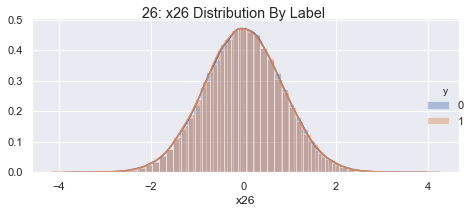

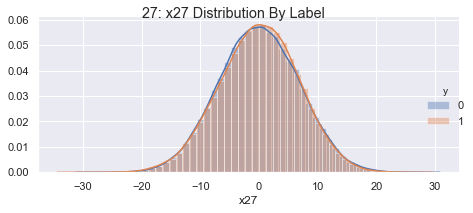

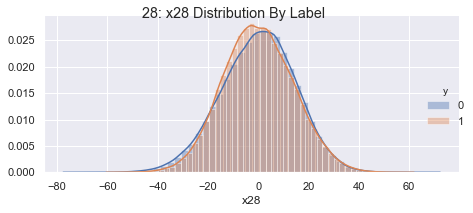

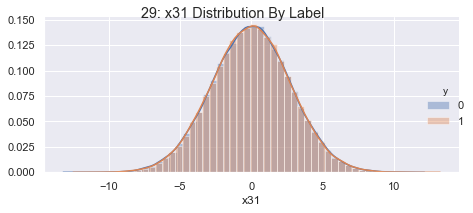

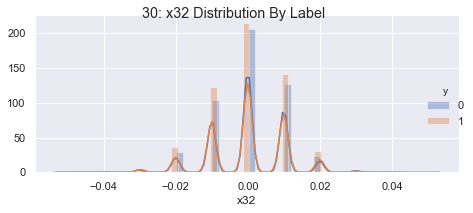

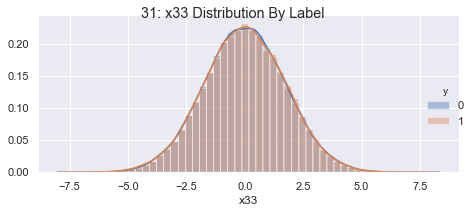

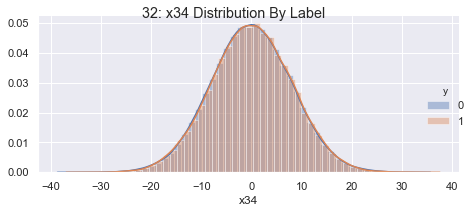

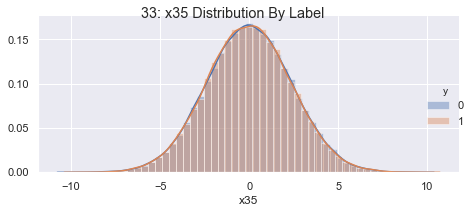

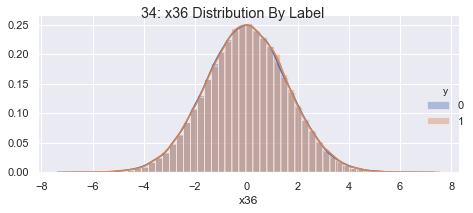

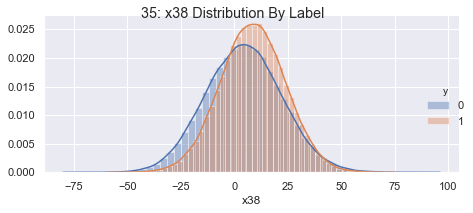

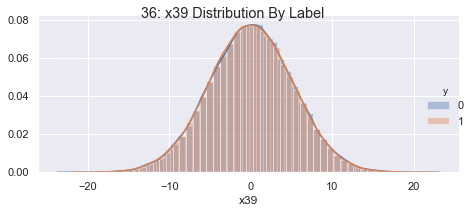

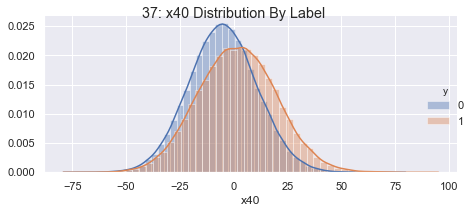

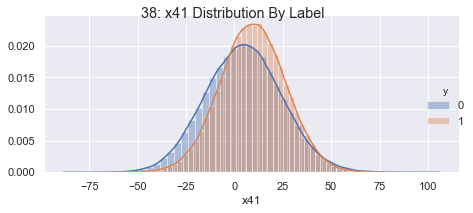

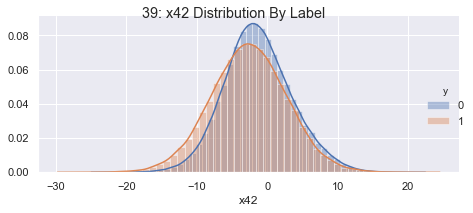

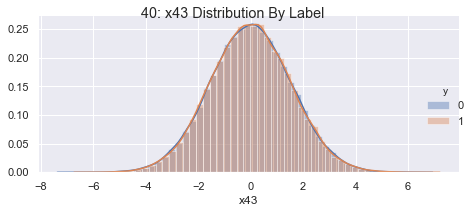

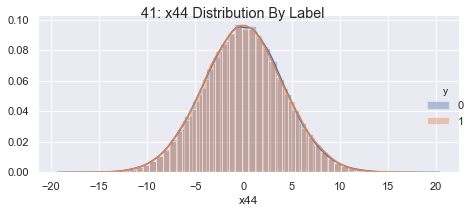

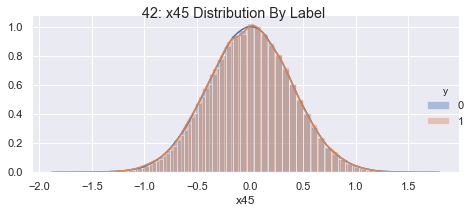

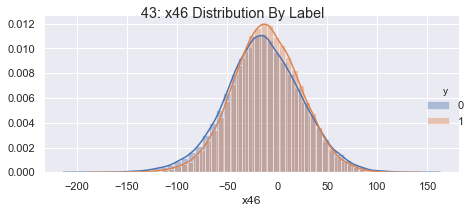

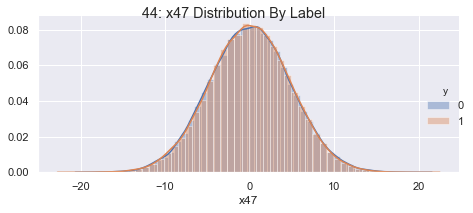

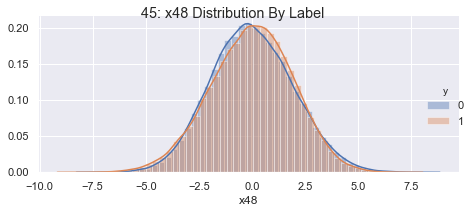

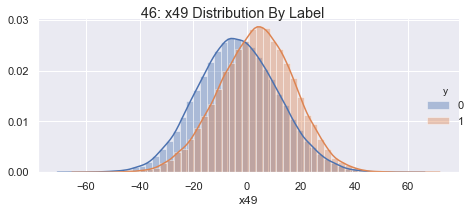

In [40]:
plt.rcParams['figure.max_open_warning']=40
plt.rcParams['figure.figsize']=(5,5)
colnames=list(df.drop(['y'], axis=1).select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(df, hue='y',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list([colnames.index(i)+1,": ",i," Distribution By Label"]))))
    plt.tight_layout()
    plt.show()

As each numerical variable displays normal distribution. Variable x2, x6, x7, x12, x20, x23, x27, x28, x38, x40, x41, x42, x46, x48,  and x49 shows clear separation of data by label. Other displayed similar distribution.

#### Response Variable

Text(0, 0.5, 'Count')

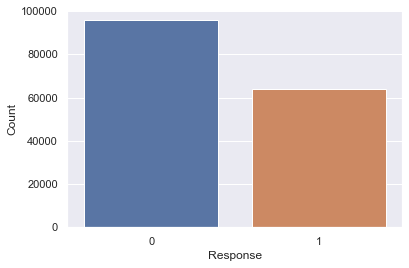

In [9]:
ax = sns.countplot(x = 'y', data = df)
ax.set_xlabel("Response")
ax.set_ylabel("Count")

A review of the response variable indicates that there are are 40.1% positive responses compared to 59.9% negative responses. This means that we might have to consider balancing the classes as we move forward, though initially the class imblance does not seem extreme. 

In [ ]:
p1 = len(df[df["y"]==1])/len(df["y"])*100
p0 = len(df[df["y"]==0])/len(df["y"])*100
print( "y = 0 : ",  len(df[df["y"]==0]), ", %.3f"%p0,"%")
print( "y = 1 : ",  len(df[df["y"]==1]), ", %.3f"%p1,"%")
print("Total Missing Values: ", df.isnull().sum().sum())

y = 0 :  95753 , 59.879 %
y = 1 :  64159 , 40.121 %
Total Missing Values:  1520


In [ ]:
df1 = df.dropna()

The effect of listwise deletion on the response variable balance was examined, but since dropping missing values did not affect the ratio of positive to negative responses we decided that at this point we would not drop records with missing numeric values and consider imputation as a possible option for those variables.    

In [ ]:
p1 = len(df1[df1["y"]==1])/len(df1["y"])*100
p0 = len(df1[df1["y"]==0])/len(df1["y"])*100
print( "y = 0 : ",  len(df1[df1["y"]==0]), ", %.3f"%p0,"%")
print( "y = 1 : ",  len(df1[df1["y"]==1]), ", %.3f"%p1,"%")
print("Total Missing Values: ", df1.isnull().sum().sum()) 

y = 0 :  94846 , 59.881 %
y = 1 :  63546 , 40.119 %
Total Missing Values:  0


#### Categorical Variables

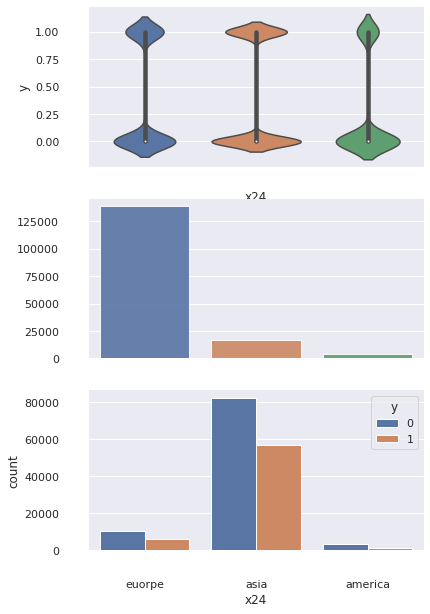

In [ ]:
count = df['x24'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x="x24", y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x24', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

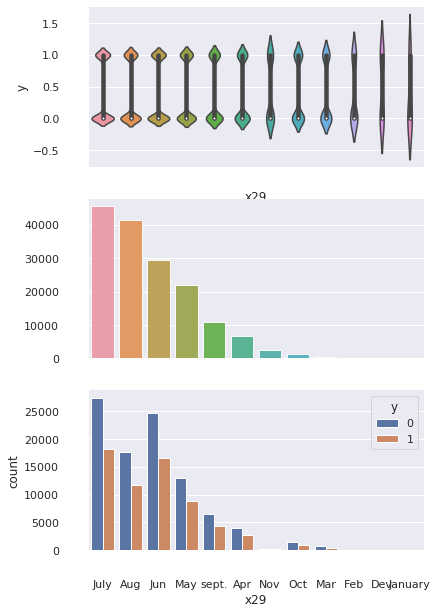

In [ ]:
count = df['x29'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x="x29", y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x29', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

Within our y variable, we cna see that the months where the count is the highest is within the summer months of May - August, which suggests there might be a seasonality.

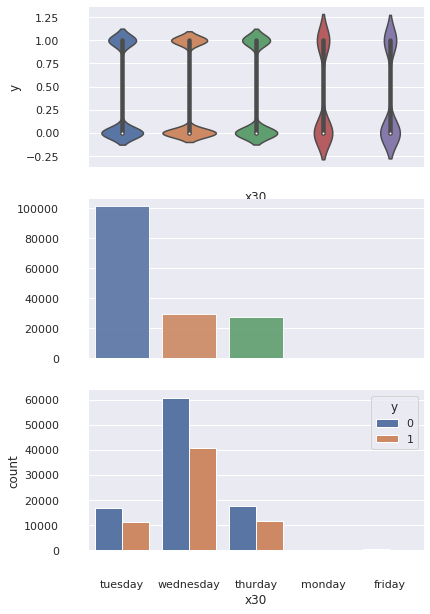

In [ ]:
count = df['x30'].value_counts()
f, axes = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
sns.barplot(count.index, count.values, alpha=0.9, ax=axes[1])
sns.violinplot(x="x30", y="y", data=df1, ax=axes[0])
sns.countplot(x = 'x30', data = df, hue = 'y', ax=axes[2])
sns.despine(offset=20, trim=True)

Specifically with the Y variable, Tuesday through Thursday have all the observations with none accounting to Friday - Monday. 

In [ ]:
print(count)

wednesday    101492
thurday       29421
tuesday       27947
friday          564
monday          488
Name: x30, dtype: int64


#### Continous Variables

In [ ]:
df_num = df.drop(['x24', 'x29', 'x30'], axis=1)

In [ ]:
df1 = df_num.iloc[:,0:9]
df2 = df_num.iloc[:,10:19]
df3 = df_num.iloc[:,20:29]
df4 = df_num.iloc[:,30:40]
df5 = df_num.iloc[:,41:47]

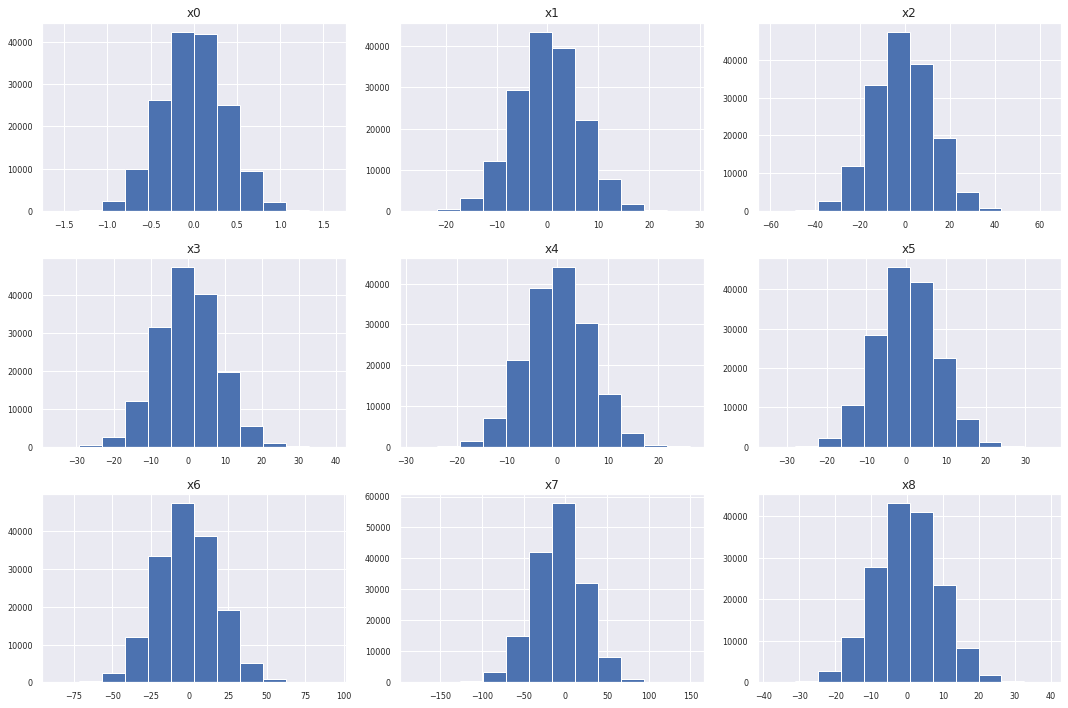

In [ ]:
df1.hist(xlabelsize = 8, ylabelsize = 8, bins = 12, figsize = (15, 10))
plt.tight_layout()
plt.show()

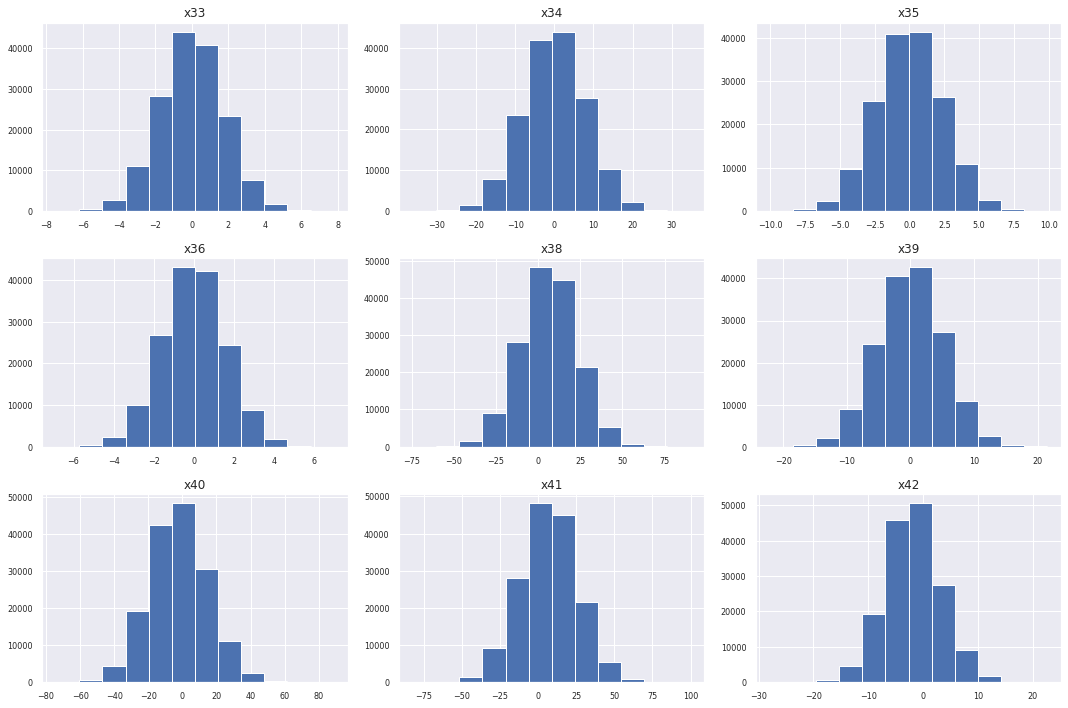

In [ ]:
df4.hist(xlabelsize = 8, ylabelsize = 8, bins = 12, figsize = (15, 10))
plt.tight_layout()
plt.show()

In [ ]:
df.corr()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
x0,1.000000,-0.001894,0.001008,-0.003418,0.000938,0.000539,0.001044,0.003795,-0.003181,-0.001624,...,0.000044,0.002126,0.001745,0.005116,-0.002366,0.000302,-0.001504,-0.000288,0.002502,0.001404
x1,-0.001894,1.000000,-0.003215,-0.000972,-0.003718,-0.001745,-0.003248,-0.002650,0.001952,-0.004797,...,0.004199,-0.001695,0.000485,-0.000970,0.001333,-0.002882,-0.000460,0.005067,0.001722,0.003049
x2,0.001008,-0.003215,1.000000,-0.000057,0.003569,0.002335,1.000000,0.203472,-0.001977,0.000772,...,0.394813,0.390239,-0.000263,0.001915,-0.000505,0.000522,-0.001938,-0.356314,-0.324882,-0.050654
x3,-0.003418,-0.000972,-0.000057,1.000000,-0.002475,-0.000781,-0.000079,-0.000739,-0.001580,-0.001441,...,0.001477,0.002363,-0.000903,-0.002632,-0.001486,0.000459,0.001250,0.000625,0.002360,0.001630
x4,0.000938,-0.003718,0.003569,-0.002475,1.000000,-0.003217,0.003418,0.002980,-0.001168,-0.003418,...,0.000419,-0.001940,0.001662,0.001621,-0.000762,-0.004279,0.000871,-0.004762,-0.004924,0.000634
x5,0.000539,-0.001745,0.002335,-0.000781,-0.003217,1.000000,0.002444,0.001154,0.002372,0.001158,...,0.003714,-0.001119,0.005606,0.005504,0.004834,-0.000230,0.004102,0.001506,0.000305,0.000999
x6,0.001044,-0.003248,1.000000,-0.000079,0.003418,0.002444,1.000000,0.203516,-0.002012,0.000879,...,0.394831,0.390191,-0.000214,0.002005,-0.000475,0.000453,-0.001816,-0.356300,-0.324894,-0.050631
x7,0.003795,-0.002650,0.203472,-0.000739,0.002980,0.001154,0.203516,1.000000,-0.006273,-0.001532,...,-0.486370,0.320250,0.000583,-0.003835,-0.001716,-0.264518,-0.004041,0.009479,-0.032364,0.014876
x8,-0.003181,0.001952,-0.001977,-0.001580,-0.001168,0.002372,-0.002012,-0.006273,1.000000,-0.001260,...,-0.000243,-0.000188,-0.000019,-0.000391,0.000098,0.003655,0.001759,-0.001268,-0.003532,-0.006178
x9,-0.001624,-0.004797,0.000772,-0.001441,-0.003418,0.001158,0.000879,-0.001532,-0.001260,1.000000,...,0.003755,-0.000693,-0.002565,-0.000928,0.003262,0.004063,0.001243,0.002575,0.005715,0.003162


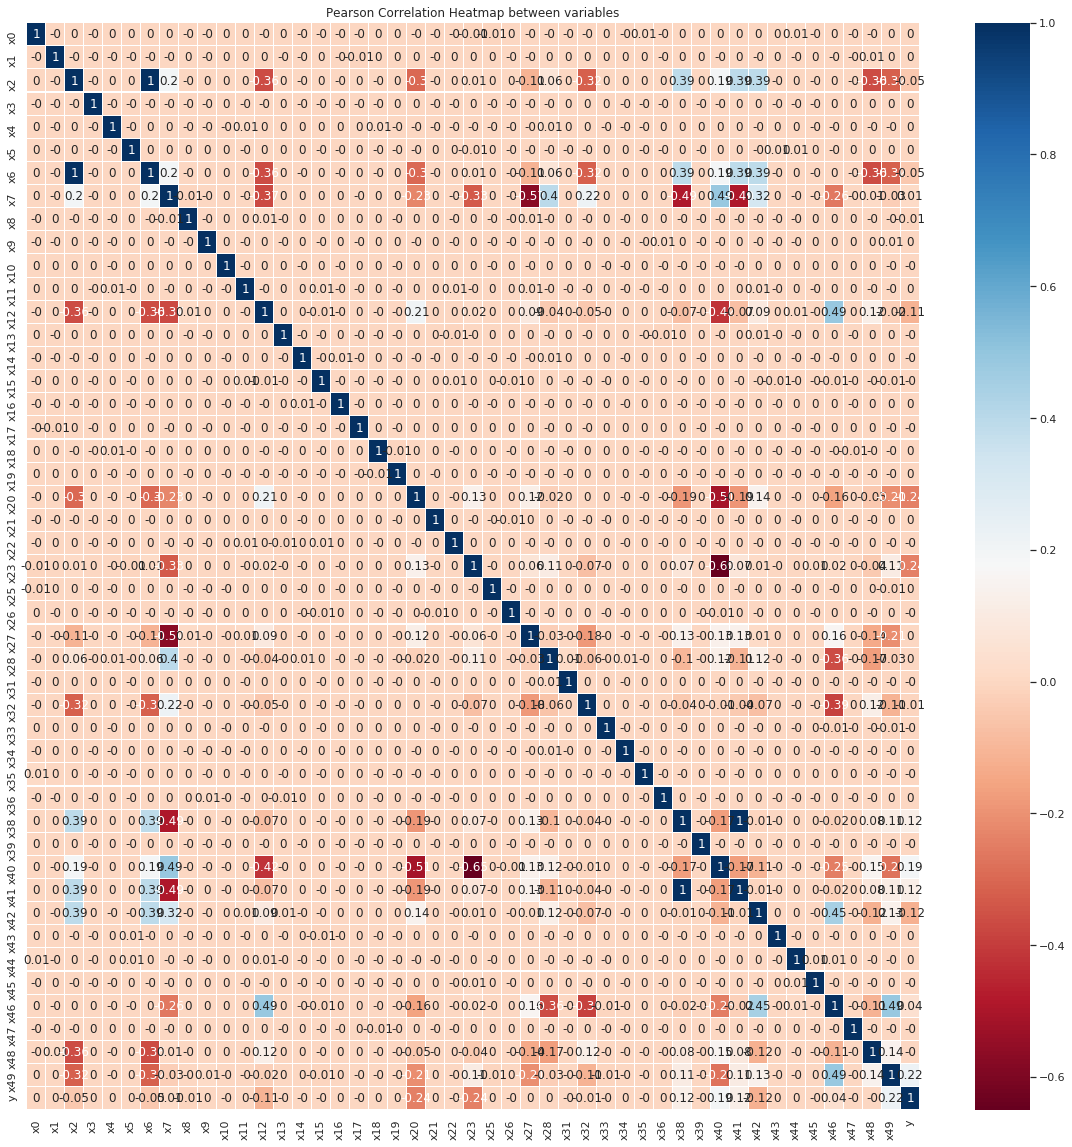

In [ ]:
ax, fig = plt.subplots(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(df.corr().round(2), annot=True, cmap = 'RdBu', linewidths = 0.1) 
plt.title("Pearson Correlation Heatmap between variables")
plt.show()

We ran a pearson coorelation among our variables and save for a few instances around the board, there wasn't a lot of strong correlations at play. The most notable were that X6 and X2 had a 1:1 relationship as well as x38 and x41.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159912 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159886 non-null  float64
 1   x1      159887 non-null  float64
 2   x2      159874 non-null  float64
 3   x3      159875 non-null  float64
 4   x4      159886 non-null  float64
 5   x5      159875 non-null  float64
 6   x6      159886 non-null  float64
 7   x7      159885 non-null  float64
 8   x8      159891 non-null  float64
 9   x9      159882 non-null  float64
 10  x10     159869 non-null  float64
 11  x11     159882 non-null  float64
 12  x12     159876 non-null  float64
 13  x13     159881 non-null  float64
 14  x14     159878 non-null  float64
 15  x15     159877 non-null  float64
 16  x16     159886 non-null  float64
 17  x17     159885 non-null  float64
 18  x18     159872 non-null  float64
 19  x19     159877 non-null  float64
 20  x20     159874 non-null  float64
 21  x21     15

Looking at the data types of our 49 variables, we can see that most are continuous floats while a few are categorical variables that we may need to create dummy objects to classify. 

In [ ]:
df['x37'] = df['x37'].str.replace(',', '')
df['x37'] = df['x37'].str.replace('$', '')
df['x37'] = df['x37'].astype('float64')

In Order for future analysis, we will need to adjust the dataframe column "x37" by removing the "$"s, ","s and "float64". this will allow us to measure these variables more easily as a classifier. 

In [ ]:
#df.loc[:, df.dtypes == 'float64'] = df.loc[:, df.dtypes == 'float64'].astype('float64')

In [ ]:
df.loc[df['x30'] =='monday', 'x30'] = 0
df.loc[df['x30'] =='tuesday', 'x30'] = 1
df.loc[df['x30'] =='wednesday', 'x30'] = 2
df.loc[df['x30'] =='thursday', 'x30'] = 3
df.loc[df['x30'] =='thurday', 'x30'] = 3
df.loc[df['x30'] =='friday', 'x30'] = 4
df.loc[df['x30'] =='saturday', 'x30'] = 5
df.loc[df['x30'] =='sunday', 'x30'] = 6
df['x30'] = df['x30'].astype('int32')

Similarly, we will convert our Day of the Week value to numerics which can be interpreted better as categorical variables. The higher number denotes the later in the week, so they can be treated continuously with context. 

In [ ]:
df['x29'].unique()

array(['July', 'Aug', 'Jun', 'May', 'sept.', 'Apr', 'Nov', 'Oct', 'Mar',
       'Feb', 'Dev', 'January'], dtype=object)

In [ ]:
df.loc[df['x29'] =='January', 'x29'] = 1
df.loc[df['x29'] =='Feb', 'x29'] = 2
df.loc[df['x29'] =='Mar', 'x29'] = 3
df.loc[df['x29'] =='Apr', 'x29'] = 4
df.loc[df['x29'] =='May', 'x29'] = 5
df.loc[df['x29'] =='Jun', 'x29'] = 6
df.loc[df['x29'] =='July', 'x29'] = 7
df.loc[df['x29'] =='Aug', 'x29'] = 8
df.loc[df['x29'] =='sept.', 'x29'] = 9
df.loc[df['x29'] =='Oct', 'x29'] = 10
df.loc[df['x29'] =='Nov', 'x29'] = 11
df.loc[df['x29'] =='Dev', 'x29'] = 12
df['x29'] = df['x29'].astype('int32')

Like the days of the week, we will convert the months to numeric values. 

In [ ]:
df['x24'].unique()

array(['euorpe', 'asia', 'america'], dtype=object)

In [ ]:
df['x24'] = df['x24'].astype(str)
df.loc[df['x24'] =='euorpe', 'x24'] = 'europe'

In [ ]:
import seaborn as sns
sns.pairplot(data=df, hue='y')

In [ ]:
#We probably need to split the test train set prior to this to eliminate data leakage
#Using an Iterative transformer here to fill in NANs
#Also stratifying the data along y

#create a holdout set
from sklearn.model_selection import train_test_split
df_x, unseen_x_test, df_y, unseen_y_test = train_test_split(df.loc[:, df.columns != 'y'], df['y'], test_size=0.30, stratify=df['y'],random_state=42)

To begin our prediction modeling, we will create a train / test split on the X and Y variables using a 70/30 ratio between training and testing. Since we have an offbalanced Y variable, we will use stratified sampling of our y values to make sure we have a significant amount of observations in each binary to best ensure our classifier is fair. 

In [ ]:
print(unseen_x_test.shape)
print(unseen_y_test.shape)

df_x.reset_index(drop=True, inplace=True)
unseen_x_test.reset_index(drop=True, inplace=True)
df_y.reset_index(drop=True, inplace=True)
unseen_y_test.reset_index(drop=True, inplace=True)

(47974, 50)
(47974,)


Now that we divided up our train and test split, we can see that our testing set has nearly 48,000 observations. While, as we know, the x dataframe will have 50 columns. 

In [ ]:
##TRAIN
#scale the test data seperately from the unseen holdout set
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

x = df_x.loc[:, df_x.dtypes == 'float64'].values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
x = imp.fit_transform(x)
x = pd.DataFrame(x)
x.columns = df_x.loc[:, df_x.dtypes == 'float64'].columns
unscaled = pd.concat([pd.DataFrame(x),df_x['x29'], df_x['x30'],pd.get_dummies(df_x['x24']), df_y], axis=1)

##HOLDOUT
#scale the test data seperately from the unseen holdout set
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)

x = unseen_x_test.loc[:, unseen_x_test.dtypes == 'float64'].values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#x_scaled = min_max_scaler.fit_transform(x)
x = imp.fit_transform(x)
x = pd.DataFrame(x)
x.columns = unseen_x_test.loc[:, unseen_x_test.dtypes == 'float64'].columns
x = pd.DataFrame(x)
one_hot = pd.get_dummies(unseen_x_test.x24)
unseen_x = pd.concat([x,unseen_x_test['x29'], unseen_x_test['x30'],one_hot], axis=1)

In [ ]:
unscaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111938 entries, 0 to 111937
Data columns (total 53 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   x0       111938 non-null  float64
 1   x1       111938 non-null  float64
 2   x2       111938 non-null  float64
 3   x3       111938 non-null  float64
 4   x4       111938 non-null  float64
 5   x5       111938 non-null  float64
 6   x6       111938 non-null  float64
 7   x7       111938 non-null  float64
 8   x8       111938 non-null  float64
 9   x9       111938 non-null  float64
 10  x10      111938 non-null  float64
 11  x11      111938 non-null  float64
 12  x12      111938 non-null  float64
 13  x13      111938 non-null  float64
 14  x14      111938 non-null  float64
 15  x15      111938 non-null  float64
 16  x16      111938 non-null  float64
 17  x17      111938 non-null  float64
 18  x18      111938 non-null  float64
 19  x19      111938 non-null  float64
 20  x20      111938 non-null  

Now that we applied our cleaned data to our x data frame, we see that we have nearly 112k observations with 46 floats and 4 int variables, what we addressed previously. 

In [ ]:
from pycaret.classification import *
#intialize the setup

exp_clf = setup(unscaled
                ,target = 'y'
                ,train_size = 0.7
                ,profile = False
                ,remove_multicollinearity = True
                ,polynomial_features = False
                ,feature_interaction = True
                ,feature_ratio = False
                ,feature_selection = True
                ,fix_imbalance = True
                ,silent=True
                #,cluster = True
                ,pca = False
                ,numeric_imputation = 'mean'
                ,normalize=True
                ,categorical_features = ['x29','x30','america','asia','europe']
                ,n_jobs=32
               )

Setup Succesfully Completed!


,Description,Value
0,session_id,1174
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(111938, 53)"
4,Missing Values,False
5,Numeric Features,47
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Next, we will use pycaret that will allow us to test different modeling methods to see which one drives the most efficient accuracy, AUC, recall, Precision, F1 score, Kappa and MCC. Since false negatives are most impactful to the cost of our model, which means we need to ensure our recall is optimizaed and prioritized over precision. 

In [ ]:
# compare all baseline models and select top 5
#top5 = compare_models(n_select = 5) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.9372,0.9814,0.9193,0.9237,0.9215,0.8691,0.8691,31.2079
1,Extra Trees Classifier,0.9318,0.9788,0.9093,0.9198,0.9145,0.8578,0.8578,2.6477
2,Light Gradient Boosting Machine,0.9169,0.9722,0.8993,0.8942,0.8967,0.8272,0.8272,2.1071
3,Random Forest Classifier,0.9100,0.9630,0.8666,0.9051,0.8854,0.8114,0.8120,1.4597
4,K Neighbors Classifier,0.8783,0.9545,0.9576,0.7859,0.8633,0.7555,0.7675,2.5836
5,Gradient Boosting Classifier,0.8721,0.9432,0.8618,0.8267,0.8439,0.7356,0.7361,433.4065
6,Extreme Gradient Boosting,0.8700,0.9422,0.8630,0.8220,0.8420,0.7317,0.7324,7.6006
7,Logistic Regression,0.8619,0.9331,0.8624,0.8067,0.8336,0.7158,0.7169,4.7835
8,SVM - Linear Kernel,0.8535,0.0000,0.8578,0.7939,0.8245,0.6991,0.7008,2.0954
9,Linear Discriminant Analysis,0.8488,0.9242,0.8590,0.7846,0.8201,0.6901,0.6922,2.4622


Running a comparision of all our baseline models we can see that catboost was our best performing with regard to Accuracy, AUC, Precision and F1 score. 

In [ ]:
catboost = create_model(estimator = 'catboost', ensemble = True, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9387,0.9812,0.9297,0.9186,0.9241,0.8728,0.8728
1,0.9363,0.9803,0.9179,0.9229,0.9204,0.8673,0.8674
2,0.9334,0.9794,0.9198,0.9146,0.9172,0.8615,0.8615
3,0.9379,0.9808,0.9173,0.9270,0.9221,0.8704,0.8705
4,0.9363,0.9804,0.9195,0.9216,0.9206,0.8674,0.8674
5,0.9326,0.9812,0.9087,0.9222,0.9154,0.8594,0.8595
6,0.9375,0.9820,0.9217,0.9223,0.9220,0.8698,0.8698
7,0.9345,0.9791,0.9131,0.9228,0.9180,0.8635,0.8635
8,0.9400,0.9815,0.9198,0.9299,0.9248,0.8749,0.8750
9,0.9338,0.9808,0.9144,0.9200,0.9172,0.8620,0.8620


To explore ways to optimize our catboost model we will perform a bagging procedure (similar to boostrap aggregating) which will take an ensemble of 10 differently sampled observations from the training set and average the results across all 10. This ensures that our catboost is not overfit to a training set and ensure's it's generalizable across all the training data. 

In [ ]:
# select best model 
best = automl(optimize = 'MCC')

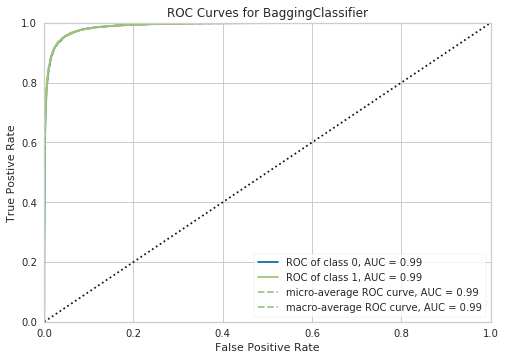

In [ ]:
plot_model(best)

Optimizing our MCC score through AutoML, we generated the ROC curve above which had a peak AUC of 0.99 for both class 0 and class 1 in our testing y value. 

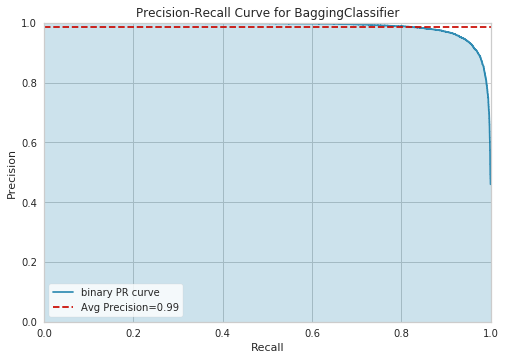

In [ ]:
plot_model(best, plot='pr')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


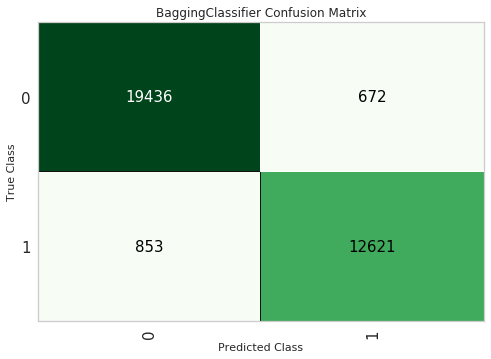

In [ ]:
plot_model(best, plot='confusion_matrix')

Here is our outputted confusion matrix on our testing set using our best performing model. In it we can see that generally we have 1,500 misclassified observations out of nearly 34,000 observations. 

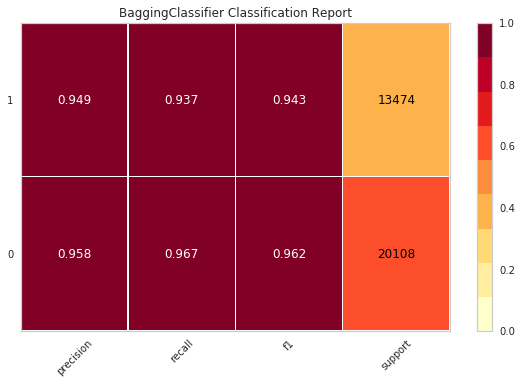

In [ ]:
plot_model(best, plot='class_report')

As mentioned before, the cost of missing on recall is more dire than precision, and here we canse see that our classifier is in the mid 90% for both groups. 

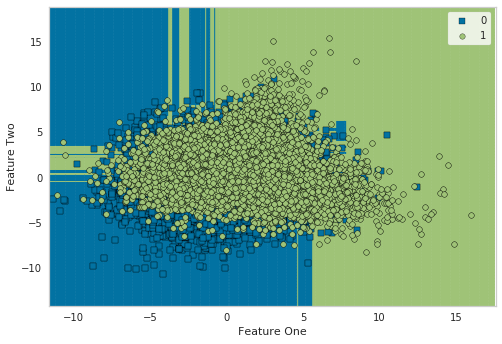

In [ ]:
plot_model(best, plot='boundary')

The plot above shows the boundaries for decisioning between observations classified as 0 and 1 in our model. 

In [ ]:
plot_model(best, plot='parameter')

,Parameters
base_estimator__thread_count,32
base_estimator__silent,True
base_estimator__random_state,1174
base_estimator,<catboost.core.CatBoostClassifier object at 0x...
bootstrap,True
bootstrap_features,False
max_features,1
max_samples,1
n_estimators,10
n_jobs,32


Looking further in our catboost tuning parameters that drove our model performance, the output is above. As you can see we employed bootstrapping on 10 estimators with no warm start. 

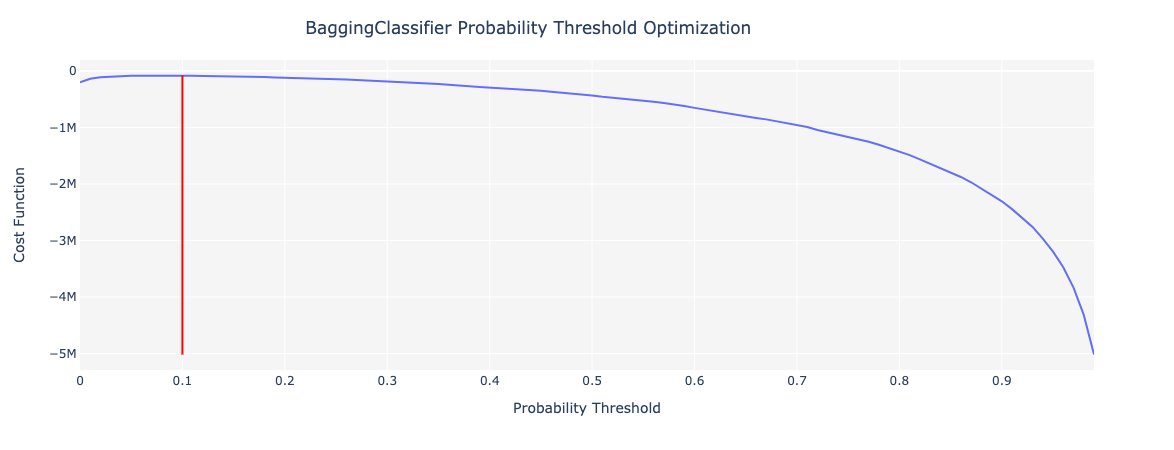

Optimized Probability Threshold: 0.1 | Optimized Cost Function: -79700


In [ ]:
# optimize threshold for trained model
optimize_threshold(best, false_positive = -10, false_negative = -500)

In [ ]:
predictions = predict_model(best, probability_threshold=0.1, data=unseen_x)

Using our best parameters, we will move forward with predicting our final confusion matrix which will inform our cost out method. 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

array([[21827,  6899],
       [  209, 19039]])

Here, we can see that our best model gave us a precision misclassification count 6,899 and a recall misclassification count of 209. While our precision is higher, it is ultimately less costly than the recall. Our aim is to ensure the misclassifications of false positives is not 50x more than the true negatives. 

In [ ]:
print ("Confusion Matrix : \n", confusion_matrix(unseen_y_test, predictions['Label']), "\n") 
print ("Accuracy  : %.3f" % accuracy_score(unseen_y_test, predictions['Label']))
print ("Precision : %.3f" % precision_score(unseen_y_test, predictions['Label']))
print ("Recall    : %.3f" % recall_score(unseen_y_test, predictions['Label']))

Confusion Matrix : 
 [[21827  6899]
 [  209 19039]] 

Accuracy  : 0.852
Precision : 0.734
Recall    : 0.989


Here's the calculation of accuracy, precision and recall which shows that we emphasized recall mostly over precision in our tuning parameters.

In [ ]:
cost = 6899*10+209*500
print("Model Cost: $%.0f" % cost )

Model Cost: $173490


Calculating every missed true negative x 500 and every fase positive by $10, across all our observations, we generated a total model cost of $173,490.

# Cost Per Unit Classified

In [ ]:
print("Model Unit Cost: $%.2f" % (cost / unseen_y_test.shape[0]) ) 

Model Unit Cost: $3.62


Per unit of our testing data set, this amounts to $3,62 per of our 48,000 observations. 